In [18]:
# Install TensorFlow
# !pip install -q tensorflow

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
2.2.0


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load Data

In [20]:
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

File ‘spam.csv’ already there; not retrieving.



In [0]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [22]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Data Preprocessing

In [0]:
df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1, inplace=True)

In [24]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [0]:
df.columns = ['labels', 'data']

In [26]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Create Binary Labels

In [27]:
X = df['data']
df['b_labels'] = df['labels'].map({'ham' : 0, 'spam' : 1})
y = df['b_labels'].values
print(df['data'])
print(y)

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: data, Length: 5572, dtype: object
[0 0 1 ... 0 0 0]


## Train Test Split

In [0]:
df_train, df_test, y_train, y_test = train_test_split(df['data'], y, test_size=0.33) 

## Preprocessing for Embedding

In [0]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)

# Get sequences of integers for each sentence
sequences_train = tokenizer.texts_to_sequences(df_train) 
sequences_test = tokenizer.texts_to_sequences(df_test)

In [30]:
# word integer mapping
word2idx = tokenizer.word_index # word integer pairs
V = len(word2idx)
print("Tokens found: ", V)

Tokens found:  7329


## Reshape Data for NN

In [31]:
# Need N x T matrix (can substitute D for T)
X_train = pad_sequences(sequences_train) # Pad sequences to make them of equal length
print("Train Sensor shape: ", X_train.shape)

T = X_train.shape[1]
print("Sequence length: ", T)

X_test = pad_sequences(sequences_test, maxlen=T)
print("Test Sensor shape: ", X_test.shape)

Train Sensor shape:  (3733, 115)
Sequence length:  115
Test Sensor shape:  (1839, 115)


# Build Model

In [0]:
N = df.shape[0] # Number of sequences
# T, the sequence length has been defined
D = 25 # Embedding dimensionality is a hyperparameter, because you get to choose any word vector sizez you want
M = 30 # Number of neurons per hidden layer

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i) # output dimensions are (V + 1, D) because embedding index starts at 1
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

model.compile(optimizer=Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [37]:
r = model.fit(X_train, y_train,
              validation_data = (X_test, y_test),
              epochs = 20)

Epoch 1/20
117/117 [==============================] - 2s 20ms/step - loss: 0.4559 - accuracy: 0.8492 - val_loss: 0.3524 - val_accuracy: 0.8679
Epoch 2/20
117/117 [==============================] - 2s 15ms/step - loss: 0.3312 - accuracy: 0.8650 - val_loss: 0.3007 - val_accuracy: 0.8679
Epoch 3/20
117/117 [==============================] - 2s 15ms/step - loss: 0.2784 - accuracy: 0.8650 - val_loss: 0.2529 - val_accuracy: 0.8679
Epoch 4/20
117/117 [==============================] - 2s 15ms/step - loss: 0.2162 - accuracy: 0.8650 - val_loss: 0.1844 - val_accuracy: 0.8679
Epoch 5/20
117/117 [==============================] - 2s 15ms/step - loss: 0.1424 - accuracy: 0.9735 - val_loss: 0.1289 - val_accuracy: 0.9799
Epoch 6/20
117/117 [==============================] - 2s 14ms/step - loss: 0.0920 - accuracy: 0.9930 - val_loss: 0.0925 - val_accuracy: 0.9891
Epoch 7/20
117/117 [==============================] - 2s 14ms/step - loss: 0.0601 - accuracy: 0.9957 - val_loss: 0.0730 - val_accuracy: 0.9880

# Evaluate Model

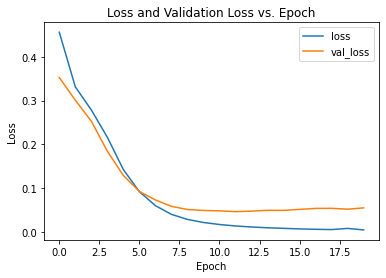

In [38]:
# Plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.title("Loss and Validation Loss vs. Epoch")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

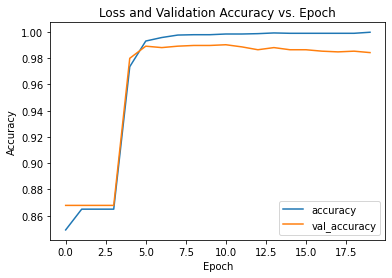

In [39]:
# Plot the loss
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.title("Loss and Validation Accuracy vs. Epoch")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()